In [26]:
# utils imports
import pdb
import time
import numpy as np
import pandas as pd
import random
from collections import deque
from copy import deepcopy as dcopy
import os
import matplotlib.pyplot as plt

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [27]:
class DQN:
    def __init__(self, memory_size=5*10**5, batch_size=32, gamma=0.99,
        exploration_max=1.0, exploration_min=0.01, exploration_decay=0.995,
        learning_rate=0.005, tau=0.125, n_actions=2, n_inputs=2):
        
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.exploration_max = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.learning_rate = learning_rate
        self.tau = tau

        self.n_actions = n_actions
        self.n_inputs = n_inputs

        self.loss_history = []
        self.fit_count = 0

        self.nodes_queue = []

        self.lin1 = nn.Linear(n_inputs, 24)
        self.lin2 = nn.Linear(24, 24)
        self.lin3 = nn.Linear(24, n_actions)
        self.model = self.create_model(n_inputs, n_actions)
        self.aux_model = self.create_model(n_inputs, n_actions)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
    def create_model(self, n_inputs, n_actions):
        model = nn.Sequential(
            nn.Linear(n_inputs, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, n_actions)
        )
        return model
        # _model = Sequential()
        # _model.add(Dense(24, input_dim=self.observation_space.shape[0], activation="relu"))
        # _model.add(Dense(24, activation="relu"))
        # _model.add(Dense(self.action_space.n))
        # _model.compile(loss="mse", 
        #                optimizer=Adam(learning_rate=self.learning_rate))

        # return _model
        
    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

    def get_action(self, state, should_explore=True):
        state = torch.Tensor(state)
        if should_explore:
            self.exploration_max *= self.exploration_decay
            self.exploration_max = max(self.exploration_min, self.exploration_max)
            if np.random.random() < self.exploration_max:
                return np.random.randint(0, self.n_actions)
        
        with torch.no_grad():
            # q_values = self.model.predict(state, verbose=0)
            q_values = self.forward(state)
            best_action = torch.argmax(q_values)
            return best_action
      
    def remember(self, _state, action, reward, _next_state, done):
        state = _state
        next_state = _next_state
        self.memory.append([state, action, reward, next_state, done])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 
        
        samples = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        targets = []
        with torch.no_grad():
            for state, action, reward, next_state, done in samples:
                target = self.forward(torch.Tensor(state))
                if done:
                    target[0][action] = reward
                else:
                    Q_future = torch.max(self.forward(torch.Tensor(next_state)))
                    target[0][action] = reward + Q_future * self.gamma
                
                targets.append(target)
            
        states = torch.cat([torch.Tensor(i) for i in states])
        targets = torch.cat(targets)
        loss = F.mse_loss(self.forward(states), targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.loss_history.append(loss)

        return self.loss_history[-1]
        
    def target_train(self):
        self.aux_model.load_state_dict(self.model.state_dict())
    
    def step(self, state, action):

        next_state = dcopy(state)
        if action == 0:
            next_state[0][0] -= 1
        else: 
            next_state[0][0] += 1
        
        done = False
        if next_state[0][0] == 0 or next_state[0][0] == 3:
            done = True

        if next_state[0][1] == 1 and next_state[0][0] == 1:
            next_state[0][1] = 0

        return next_state, done

    def calc_reward(self, state, next_state, done):
        if next_state[0][0] == 0:
            return -10
        elif next_state[0][0] == 3:
            return 10
        elif state[0][1] == 1 and next_state[0][0] == 1:
            return 3
        else:
            return 0

    def reset_env(self):
        done = False
        state = [[2,1]]
        return state, done
        
    # def save_model(self, fn):
    #     self.aux_model.save('dqn-models/'+fn)
    
    # def load_model(self, filename):
    #     self.aux_model = tf.keras.models.load_model(filename)

    # def print_model(self):
    #     self.aux_model.summary()

DDQN = DQN()

In [31]:
episodes = 5000
rewards = []
losses = []
r = []
inner_loss = []
for ep in range(episodes):
    state, done = DDQN.reset_env()
    r = []
    l = []
    while not done:
        action = DDQN.get_action(state)
        next_state, done = DDQN.step(state, action)
        reward = DDQN.calc_reward(state, next_state, done)
        
        DDQN.remember(dcopy(state), action, reward, dcopy(next_state), done)
        # print("State: ", state, "Action: ", action, "Reward: ", reward, "Next State: ", next_state)
        if len(DDQN.memory) > 100:  
            loss = DDQN.replay() 
            l.append(loss)

        state = dcopy(next_state)
        r.append(reward)
    
    DDQN.target_train()
    losses.append(torch.mean(torch.Tensor(l)))
    rewards.append(torch.sum(torch.Tensor(r)))
    if len(DDQN.memory) > 100:  DDQN.target_train()
    print(f"Episode:{ep}, Ep Reward: {rewards[-1]}, Last Loss: {losses[-1]}, Exploration: {DDQN.exploration_max}")

Episode:0, Ep Reward: 10.0, Last Loss: 47.42756652832031, Exploration: 0.01
Episode:1, Ep Reward: 10.0, Last Loss: 49.15367889404297, Exploration: 0.01
Episode:2, Ep Reward: 10.0, Last Loss: 49.007164001464844, Exploration: 0.01
Episode:3, Ep Reward: 10.0, Last Loss: 49.007164001464844, Exploration: 0.01
Episode:4, Ep Reward: 10.0, Last Loss: 48.98904037475586, Exploration: 0.01
Episode:5, Ep Reward: 10.0, Last Loss: 46.15774917602539, Exploration: 0.01
Episode:6, Ep Reward: 10.0, Last Loss: 50.57838821411133, Exploration: 0.01
Episode:7, Ep Reward: 10.0, Last Loss: 50.5693244934082, Exploration: 0.01
Episode:8, Ep Reward: 10.0, Last Loss: 50.5693244934082, Exploration: 0.01
Episode:9, Ep Reward: 10.0, Last Loss: 47.58314514160156, Exploration: 0.01
Episode:10, Ep Reward: 10.0, Last Loss: 50.5693244934082, Exploration: 0.01
Episode:11, Ep Reward: 10.0, Last Loss: 48.98904037475586, Exploration: 0.01
Episode:12, Ep Reward: 10.0, Last Loss: 50.5693244934082, Exploration: 0.01
Episode:13,

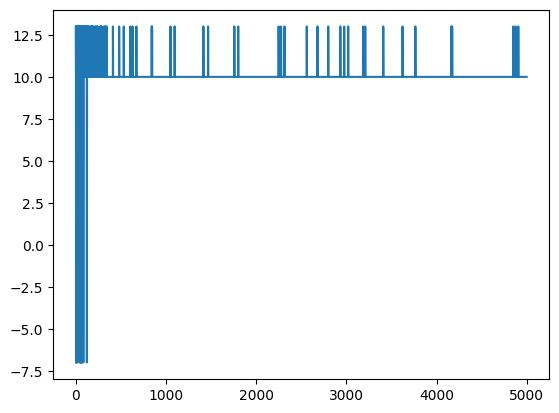

In [29]:
plt.plot(rewards)

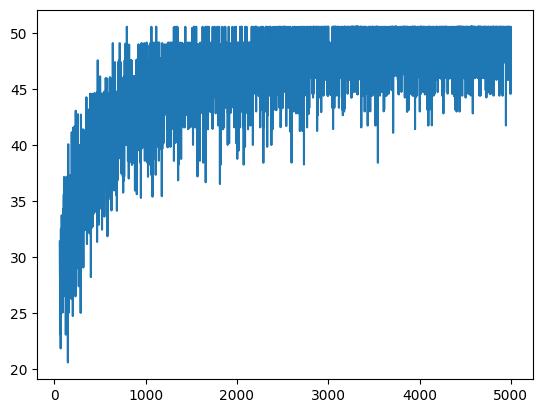

In [30]:
plt.plot(losses)